# Hotel Cancellation Analysis

Goal: Analyze hotel booking cancellation patterns and uncover key risk factors.

---

## Import Libraries

We’ll use Pandas for data manipulation, Seaborn and Matplotlib for visualizations, and Scipy for basic statistical testing.

In [1]:
# import libraries needed

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

---
## Load Dataset

Load the Hotel Booking Demand dataset in CSV format, previously downloaded from Kaggle.


In [2]:
# reading csv

raw_data = pd.read_csv("hotel_bookings.csv")
raw_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


---
## Data Overview

Before diving into visual analysis, this section explores the raw structure of the dataset, feature selection, and cleaning steps.


### Dataset Summary

In [3]:
raw_data.shape

(119390, 32)

119,390 rows and 32 columns

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

This dataset has 119,390 rows and 32 columns. It includes categorical, integer, and float features, with some missing values identified in certain columns.

### Feature Selection

The original dataset contains 32 columns and 119,390 rows.

For this analysis, I selected 10 key features based on their relevance to cancellation behavior:

- **Booking status**: `hotel`, `is_canceled`  
- **Customer segmentation**: `customer_type`, `is_repeated_guest`  
- **Distribution channels & timing**: `lead_time`, `distribution_channel`
- **Pricing & arrival details**: `adr`, `arrival_date_year`, `arrival_date_month`, `arrival_date_day_of_month`

In [5]:
# feature selection

main_df = raw_data[[
    'hotel',                      # hotel type
    'is_canceled',                # main topic
    'customer_type',              # customer type
    'distribution_channel',       # distribution channel
    'is_repeated_guest',          # is the guest loyal or not
    'lead_time',                  # time range between booking and check-in
    'adr',                        # average daily rate
    'arrival_date_year',          # year of arrival
    'arrival_date_month',         # month of arrival
    'arrival_date_day_of_month'    # day of arrival
]]
main_df.shape

(119390, 10)

119,390 rows and 10 columns.

### Data Quality Checks: Missing & Duplicate Values

In [6]:
main_df.isnull().sum().sort_values(ascending=False).head()

hotel                   0
is_canceled             0
customer_type           0
distribution_channel    0
is_repeated_guest       0
dtype: int64

No missing values were found in the selected 10 features.

In [7]:
main_df.duplicated().sum()

np.int64(39631)

A total of **39,631 duplicated rows** were found.

Since these records are exact copies and don’t add analytical value, they were removed to avoid bias in the analysis.

### Data Cleaning

#### Drop Erroneous Records
In the original dataset, there are records where `is_canceled = 0` (booking not canceled), but `adr = 0`.  
This combination is inconsistent: if a guest stayed at the hotel, the average daily rate (`adr`) should not be zero.

> Based on this logic, rows with `is_canceled = 0` and `adr = 0` were considered erroneous and dropped from the dataset.

In [8]:
# drop row which has 0 value, both in is_canceled and adr

main_df = main_df[~((main_df['adr'] <= 0) & (main_df['is_canceled'] == 0))].reset_index(drop=True)
main_df.shape

(117643, 10)

#### Remove Duplicate Records
Duplicate rows were found in the dataset using `main_df.duplicated().sum()`.  
Since these records provide no additional value, they were dropped to avoid data skew in the analysis.

> Total duplicates removed: 39,631 rows

In [9]:
main_df = main_df.drop_duplicates()
main_df.shape

(78353, 10)

The shape is change to 78,353 rows and 10 columns.

### Feature Creation

Combined `arrival_date_year`, `arrival_date_month`, and `arrival_date_day_of_month` into single datetime column `arrival_date`


In [10]:
# combine 3 separates columns (y, m, and d) to one new column
# 1. change month representation: char to number(in string)
month_map = {
    "January": "01",
    "February": "02",
    "March": "03",
    "April": "04",
    "May": "05",
    "June": "06",
    "July": "07",
    "August": "08",
    "September": "09",
    "October": "10",
    "November": "11",
    "December":"12"}

main_df['arrival_date_month_num'] = main_df['arrival_date_month'].map(month_map)

# 2. make a new column
main_df['arrival_date'] = pd.to_datetime(
                            main_df['arrival_date_year'].astype(str) + '-' +
                            main_df['arrival_date_month_num'] + '-' +
                            main_df['arrival_date_day_of_month'].astype(str),
                            format='%Y-%m-%d')
main_df.shape

(78353, 12)

### Export for Tableau

Final cleaned dataset saved to CSV for dashboarding

In [11]:
# save to csv

main_df.to_csv("main_df.csv", index=False)

---
## Exploratory Data Analysis

This section explores booking cancellation behavior through visual analysis to uncover patterns and relationships between customer types, booking channels, timing, and price.

### Q1: What is the overall cancellation rate?

Visualizing the overall proportion of canceled vs non-canceled bookings.

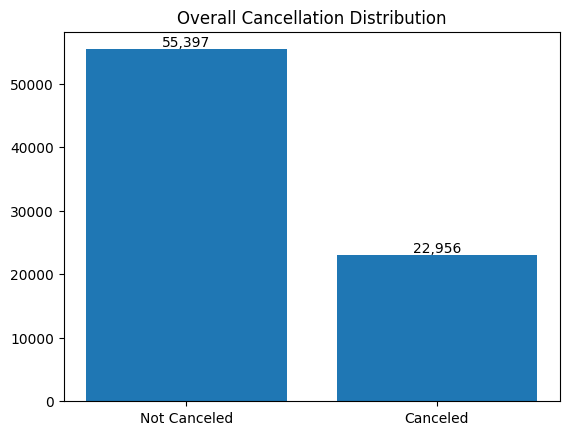

In [12]:
cancel_count = main_df['is_canceled'].value_counts()

container = plt.bar(cancel_count.index, cancel_count.values)
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.bar_label(container, fmt='{:,.0f}')
plt.title('Overall Cancellation Distribution')
plt.show()

> 🧠 **Insight**: Approximately **28,96%** of all bookings were canceled.
This provides a baseline before breaking down by hotel type or other segments.

### Q2: Which hotel type has a higher cancellation rate?

We approached this question from two perspectives to better understand both risk and impact.

---
#### 1. Cancellation Rate per Hotel Type

This view shows the proportion of canceled bookings within each hotel type.

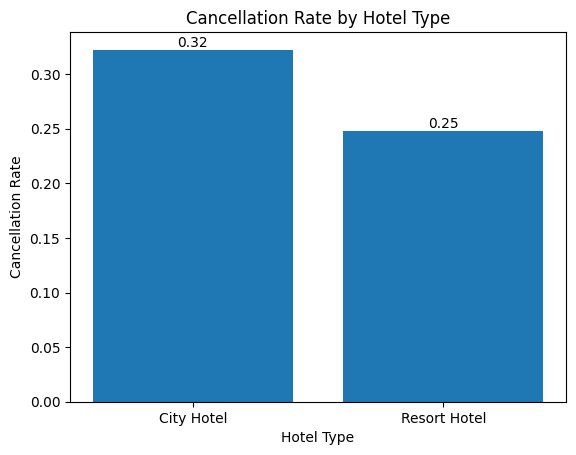

In [13]:
# Cancellation rate by hotel type
compare_cancel = main_df.groupby('hotel')['is_canceled'].mean()

container = plt.bar(compare_cancel.index, compare_cancel.values)
plt.title('Cancellation Rate by Hotel Type')
plt.ylabel('Cancellation Rate')
plt.bar_label(container, fmt='%.2f')
plt.xlabel('Hotel Type')
plt.show()

> 🧠 **Insight:** Out of all bookings, **32%** were canceled in City Hotels, compared to **25%** in Resort Hotels.  
This indicates that City Hotels have a higher cancellation rate and may require closer attention to booking behavior.

#### 2. Share of Total Cancellations

This view shows which hotel type contributes more to total cancellations.

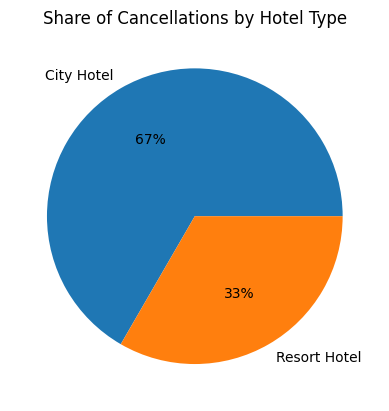

In [14]:
# Filter only canceled bookings
canceled = main_df[main_df['is_canceled'] == 1]

# Group by hotel to count how many cancellations per type
cancel_share = canceled['hotel'].value_counts()

# Plot
plt.pie(cancel_share, labels=cancel_share.index, autopct='%.0f%%')
plt.title('Share of Cancellations by Hotel Type')
plt.show()


> 🧠 **Insight:** Of all canceled bookings, **67%** came from City Hotels.  
This makes them the largest contributor to overall cancellations, which could have a greater impact on business performance.


### Q3: How does customer type relate to cancellations?


Analyzing which customer types (transient, group, etc.) cancel the most.

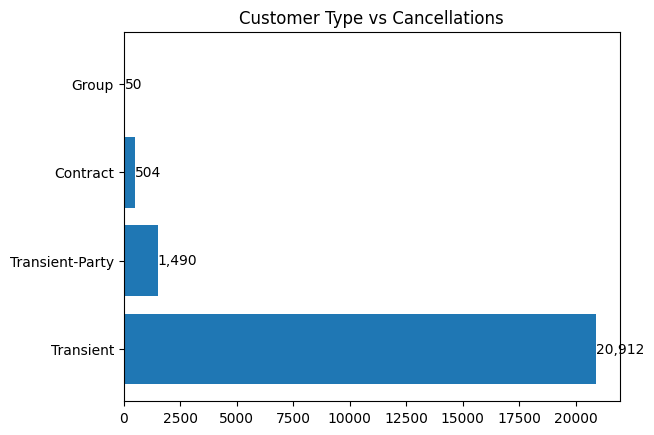

In [15]:
# Group by customer to count how many cancellations per type
cancel_customer = canceled['customer_type'].value_counts()

# Plot
container = plt.barh(cancel_customer.index, cancel_customer.values)
plt.bar_label(container, fmt='{:,.0f}')
plt.title('Customer Type vs Cancellations')
plt.show()

> 🧠 **Insight:** Out of 23,193 canceled bookings, **Transient customers** accounted for the majority with **21,056 cancellations**.  
Transient customers typically travel independently for business or leisure, booking short stays at standard rates, making them the most cancellation-prone segment.

This pattern suggests that cancellation strategies could focus more on transient guests, such as requiring confirmations, offering incentives for commitment, or adjusting flexible booking policies.

### Q4: Which distribution channels are associated with higher cancellations?

Identifying the cancellation rate across different booking channels.

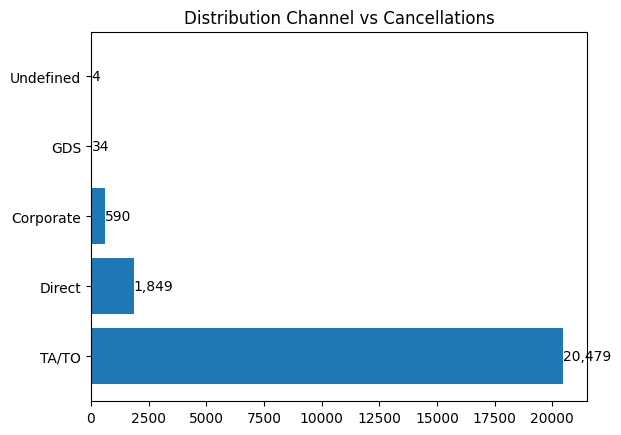

In [16]:
# Group by customer to count how many cancellations per type
cancel_channel = canceled['distribution_channel'].value_counts()

# Plot
container = plt.barh(cancel_channel.index, cancel_channel.values)
plt.bar_label(container, fmt='{:,.0f}')
plt.title('Distribution Channel vs Cancellations')
plt.show()

> 🧠 **Insight:** Out of 23,193 canceled bookings, **TA/TO (Travel Agent/Tour Operator)** channels accounted for the majority with **20,683 cancellations**.  
This makes sense, as these channels offer easier and less personal booking experiences — which may lead to higher cancellation tendencies.

Consider monitoring cancellation trends specifically from agent-driven bookings, or reviewing cancellation policies on TA/TO platforms.

### Q5: Is there relationship between lead time and cancellation

Plotting lead time distribution for canceled vs non-canceled bookings.

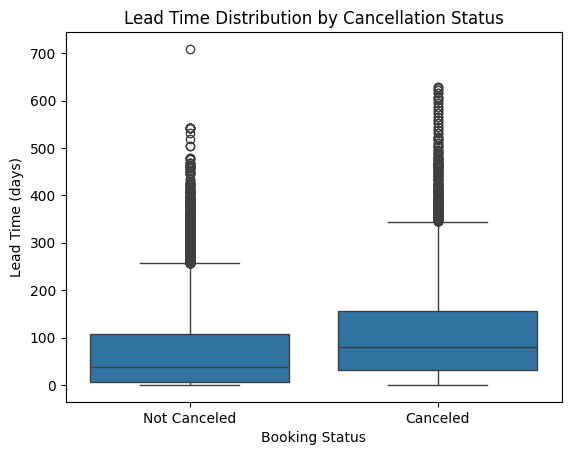

In [17]:
sns.boxplot(x='is_canceled', y='lead_time', data=main_df)
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.title('Lead Time Distribution by Cancellation Status')
plt.xlabel('Booking Status')
plt.ylabel('Lead Time (days)')
plt.show()

> 🧠 **Insight:** Although cancellations tend to have longer lead times on average, the longest lead times (over 700 days) are actually found among bookings that were not canceled, indicating exceptions to the overall trend.

### Q6: Is there relationship between average daily rate and cancellation

Plotting average daily rate distribution for canceled vs non-canceled bookings.

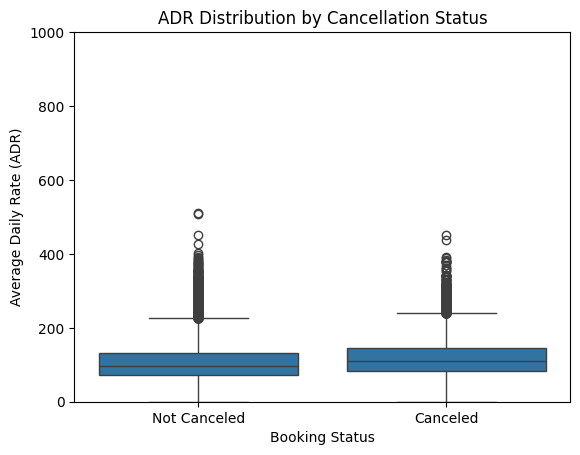

In [18]:
sns.boxplot(x='is_canceled', y='adr', data=main_df)
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.title('ADR Distribution by Cancellation Status')
plt.xlabel('Booking Status')
plt.ylabel('Average Daily Rate (ADR)')
plt.ylim(0,1000)
plt.show()

> 🧠 **Insight:** Average Daily Rate (ADR) does not appear to significantly impact cancellation behavior.  
In fact, the ADR for non-canceled bookings tends to be slightly higher than for canceled ones, it suggesting that price is not the primary factor influencing guest decisions to cancel.

### Q7: Do loyal (repeat) guests cancel less often?

Analyzing cancellation rates for repeated vs new guests.

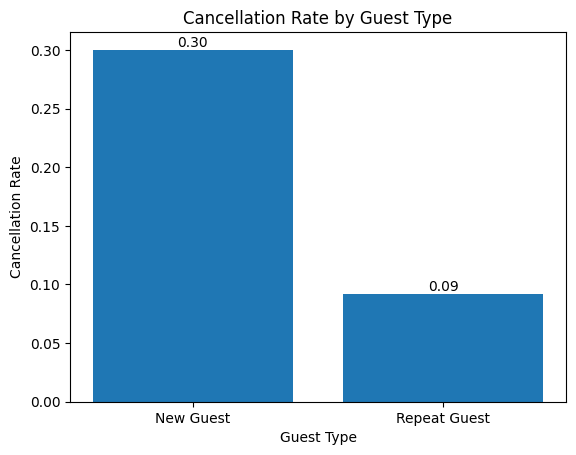

In [19]:
# Cancellation rate by guest type
compare_guest = main_df.groupby('is_repeated_guest')['is_canceled'].mean()

container = plt.bar(compare_guest.index, compare_guest.values)
plt.xticks([0, 1], ['New Guest', 'Repeat Guest'])
plt.bar_label(container, fmt='%.2f')
plt.title('Cancellation Rate by Guest Type')
plt.xlabel('Guest Type')
plt.ylabel('Cancellation Rate')
plt.show()

> 🧠 **Insight:** Repeat guests have significantly lower cancellation rates, suggesting loyalty reduces churn.

### Q8: How have cancellation trends evolved from 2015 to 2017?

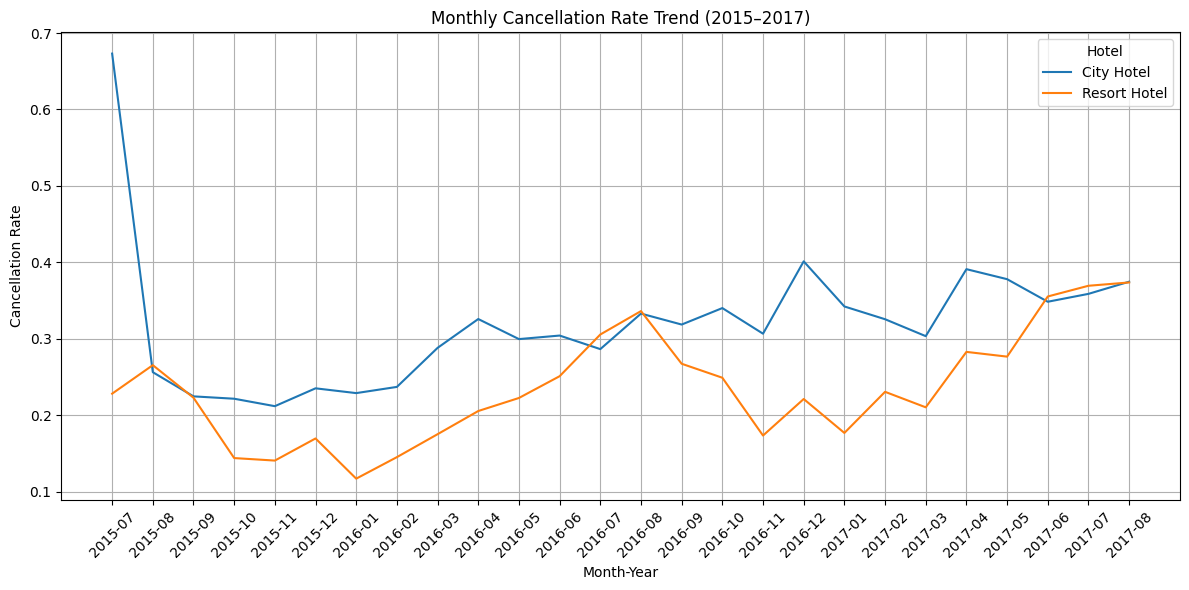

In [20]:
# Extract 'Month Year' from 'arrival_date'
main_df['Month Year'] = main_df['arrival_date'].dt.to_period('M')

# Total bookings per hotel per month
monthly_total = main_df.groupby(['hotel', 'Month Year'])['is_canceled'].count().reset_index(name='total_bookings')

# Total cancellations per hotel per month
monthly_canceled = main_df.groupby(['hotel', 'Month Year'])['is_canceled'].sum().reset_index(name='canceled')

# Merge both
cancel_trend_monthly = pd.merge(monthly_total, monthly_canceled, on=['hotel', 'Month Year'])

# Count cancel rate
cancel_trend_monthly['cancel_rate'] = cancel_trend_monthly['canceled'] / cancel_trend_monthly['total_bookings']

plt.figure(figsize=(12, 6))

for hotel in cancel_trend_monthly['hotel'].unique():
    data = cancel_trend_monthly[cancel_trend_monthly['hotel'] == hotel]
    plt.plot(
        data['Month Year'].astype(str),
        data['cancel_rate'],
        label=hotel
    )

plt.title('Monthly Cancellation Rate Trend (2015–2017)')
plt.xlabel('Month-Year')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)
plt.legend(title='Hotel')
plt.grid(True)
plt.tight_layout()
plt.show()

> 🧠 **Insight:** The cancellation rate shows a fluctuating trend over time, with no consistent linear pattern, suggesting that cancellations are influenced by seasonal or external factors.  
For **City Hotels**, notable spikes occurred in **July 2015 (peak)**, **December 2016**, and **April 2017**.  
Meanwhile, **Resort Hotels** experienced consistently higher cancellations during **June to August** across all three years (2015–2017), possibly due to summer travel season volatility.

---
## Key Takeaways from EDA

Here’s a summary of the main findings from the analysis of hotel booking cancellations:

- 🏨 **Hotel Type**  
  City Hotels have a higher cancellation rate (31%) compared to Resort Hotels (24%), and also contribute to 67% of all canceled bookings — making them the main source of cancellation impact.

- 👥 **Customer Type**  
  Transient customers account for most cancellations (21,056 out of 23,193), indicating that individual travelers are more likely to cancel compared to groups or contract-based guests.

- 🛎️ **Distribution Channel**  
  Bookings made through **TA/TO (Travel Agent/Tour Operator)** dominate cancellations with 20,683 cases, suggesting these indirect channels are more prone to drop-offs.

- ⏳ **Lead Time**  
  Canceled bookings tend to have longer lead times than non-canceled ones, which may reflect higher uncertainty for guests who book far in advance.

- 💰 **ADR (Average Daily Rate)**  
  No strong relationship is observed between ADR and cancellation. Surprisingly, non-canceled bookings often have slightly higher rates, suggesting price is not the main driver of cancellation.

- 🔁 **Loyalty (Repeat Guest)**  
  Repeat guests cancel far less frequently than new guests. This supports the idea that loyalty is a strong predictor of booking reliability.

These findings provide actionable insights for hotel management to optimize booking policies, target high-risk segments, and design better loyalty or pricing strategies.

---
## Business Recommendations

Based on the analysis, the following recommendations are proposed:

1. **Monitor and improve cancellation policies for City Hotels**, as they contribute to the majority of cancellations. Consider stricter confirmation processes or targeted reminders.

2. **Segment and target transient customers** with clearer cancellation terms or loyalty incentives, since they are the most likely to cancel.

3. **Review partnerships with TA/TO channels**, as bookings from these channels have a high cancellation rate. Explore performance-based agreements or stricter rebooking conditions.

4. **Leverage repeat guests** by offering loyalty perks, early booking deals, or personalized services, as they are highly reliable.

5. **Analyze high lead time bookings** for additional risk signals (e.g., from specific channels or countries) and consider proactive reconfirmation before stay.

6. **Price does not seem to drive cancellations**, so avoid relying solely on ADR adjustments to reduce drop-off, focus instead on behavioral factors.